# Fake News prediction

What are fake news?
...

## Libary import

In [2990]:
reset -fs

In [2991]:
%matplotlib inline
RSEED = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile

#preprocessing
import nltk 
import re
from sklearn.model_selection import train_test_split

#EDA
from wordcloud import WordCloud

#model
from sklearn import model_selection

## for bag-of-words
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import feature_extraction, preprocessing, model_selection
from sklearn import feature_selection, metrics, naive_bayes, pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# word2vector
import gensim
import gensim.downloader as gensim_api
from sklearn import manifold
from sklearn.manifold import TSNE
from tensorflow.keras import models, layers, preprocessing as kprocessing
import tensorflow as tf
from keras.utils.vis_utils import pydot
from keras.utils import plot_model
from keras import backend as K

## bert language model
import transformers


## Loading data

In [2992]:
data_overview = pd.read_csv('overview.csv')
data_overview.veracity.value_counts()

mostly true                  1264
mixture of true and false     212
mostly false                   87
no factual content             64
Name: veracity, dtype: int64

In [2993]:
data_overview.head

<bound method NDFrame.head of            XML        portal orientation                   veracity  \
0     0000.xml           abc  mainstream                mostly true   
1     0001.xml           abc  mainstream                mostly true   
2     0002.xml           abc  mainstream                mostly true   
3     0003.xml           abc  mainstream                mostly true   
4     0004.xml           abc  mainstream                mostly true   
5     0005.xml           abc  mainstream                mostly true   
6     0006.xml           abc  mainstream                mostly true   
7     0007.xml           abc  mainstream         no factual content   
8     0008.xml           abc  mainstream                mostly true   
9     0009.xml           abc  mainstream                mostly true   
10    0010.xml           abc  mainstream                mostly true   
11    0011.xml           abc  mainstream                mostly true   
12    0012.xml           abc  mainstream       

In [2994]:
data = pd.read_csv('BuzzData.csv')

In [2995]:
data.sample(5)

,article,prediction
824,"Even if you are President Obama, your jokes ne...",3
355,Supporters of Republican presidential nominee ...,3
315,While presidential nominees Donald Trump and H...,0
517,A well known Black Lives Matter activist calle...,3
1475,A cafeteria worker in a Pennsylvania school di...,3


In [2996]:
data.article[42]

"There have been so many deaths in country music over the past couple of months, and we thought that we were going to have to say goodbye to another legend Saturday night. It was a normal Saturday night at the Cornstock Concert on the Hill in Garnett, Kansas until Eddie Montgomery collapsed on stage in the middle of his performance. Many of you probably know the country star from the country duo Montgomery Gentry.  Montgomery Gentry was founded in 1999 when Eddie Montgomery and Troy Gentry came together and graced us all with their talents. The country duo has released 6 studio albums since their big debut and has had several No. 1 hits such as “If You Ever Stop Loving Me”, “Something to Be Proud Of”, “Lucky Man”, “Back When I Knew It All” and “Roll with Me”. The duo rose to fame shortly after the start of their career and they have continued to be a country favorite over the years. The duo was performing at their concert Saturday (September 24th) when Eddie Montgomery collapsed on the

## Looking at data

###  Mean of length article (in words)

In [2997]:
for x in data.article:
    len_article = np.mean(len(x.split()))

In [2998]:
len_article

215.0

### Distribution of article (by length)

In [2999]:
# create column for length of article
dist_article = []
for x in data.article:
    dist_article.append(len(x.split()))
data['Article_length'] = dist_article

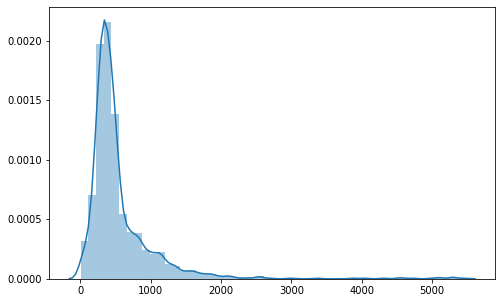

In [3000]:
plt.figure(figsize=(8,5))
ax = sns.distplot(dist_article)

### Distribution by subject

# Data cleaning

- check for missing values
- remove empty article
- check for duplicated article
- combine categories
- remove outlier

In [3001]:
#check for missing values
data.isnull().sum()

article           0
prediction        0
Article_length    0
dtype: int64

In [3002]:
#find empty article 
empty_list = data[data['article'] == 'The document has moved here.']
print(len(empty_list))
print(empty_list)

14
                           article  prediction  Article_length
94    The document has moved here.           3               5
145   The document has moved here.           3               5
308   The document has moved here.           1               5
429   The document has moved here.           0               5
724   The document has moved here.           3               5
846   The document has moved here.           2               5
908   The document has moved here.           3               5
913   The document has moved here.           0               5
1003  The document has moved here.           3               5
1081  The document has moved here.           2               5
1137  The document has moved here.           1               5
1335  The document has moved here.           3               5
1456  The document has moved here.           3               5
1461  The document has moved here.           2               5


In [3003]:
# drop empty articles
data.drop(data[data['article'] == 'The document has moved here.'].index , inplace=True)
data.shape

(1590, 3)

In [3004]:
# find dupilcated article
dupl = data[data.duplicated(['article'])]
print(len(dupl))
print(dupl)

34
                                                article  prediction  \
223   (CNN)The circus of politics can often be a dis...           2   
231   (CNN)Hillary Clinton forced Donald Trump onto ...           3   
276   (CNN)Debate stages have long doubled as presid...           3   
332   Washington (CNN)Republicans are preparing for ...           3   
376   Washington (CNN)The battle over gun rights ret...           3   
474   (CNN)Ukrainian President Petro Poroshenko says...           3   
570   Washington (CNN)New York City Mayor Bill de Bl...           3   
734   WashingtonSince we last updated the CNN battle...           3   
771   (CNN)Sen. Jeff Sessions pilloried former Presi...           3   
829   Washington (CNN)The cast of "The West Wing" is...           3   
1023  (CNN)Even if their preferred candidate wins, a...           3   
1128  (CNN)Hillary Clinton holds a solid 6-point lea...           3   
1158  Washington (CNN)Hillary Clinton and Donald Tru...           3   
116

In [3005]:
# remove duplicate
data.drop_duplicates(keep='first', inplace=True)
data.shape

(1557, 3)

In [3006]:
#removes = data.article.isin(["EDITOR’S NOTE:"]).index

In [3007]:
#CNN

In [3008]:
#combine and drop categories of prediciton
data.prediction.unique()
data.prediction.value_counts()

3    1210
0     206
1      80
2      61
Name: prediction, dtype: int64

In [3009]:
#data.prediction.drop(['2'])
index_2 = data[data['prediction'] == 2].index
data.drop(index_2, inplace=True)

In [3010]:
data.shape

(1496, 3)

In [3011]:
# combine prediction of mostly & mixture of true and false since we are looking for fake news
# -> dataset with prediction: 0 = mostly True news
#                             1 = mostly Fake News & article with some fake news
data.prediction.replace(0, 1, inplace = True)
data.prediction.replace(3, 0, inplace = True)
data.prediction.value_counts()

0    1210
1     286
Name: prediction, dtype: int64

## Handling outliers
since we know that the distribution of length of words in the sample isn't Gaussian,
we can't use the standard deviation of the sample as a cut-off 
therefore we use Interquartile Range Method

In [3012]:
# calculate interquartile range
q25, q75 = percentile(data.Article_length, 25), percentile(data.Article_length, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [idx for idx,x in data.Article_length.iteritems() if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data.Article_length if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=307.000, 75th=599.500, IQR=292.500
Identified outliers: 161
Non-outlier observations: 1335


In [3013]:
# number of outliers
len(outliers)

161

In [3014]:
# remove outliers
data.drop(outliers, inplace=True)

In [3015]:
data.shape

(1335, 3)

In [3016]:
X = data['article']
y = data['prediction']

In [3017]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

# Exploratory data analysis (EDA)

## Fake News and True News

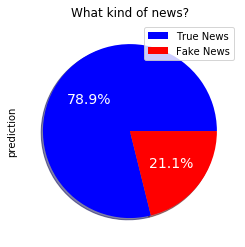

In [3018]:
Fig_age_survivial = (data.prediction.value_counts()
                     .plot.pie(autopct='%1.1f%%'
                               ,shadow=True
                               ,colors=['blue','red']
                               ,textprops=dict(color="w",size='14'))
                    )
plt.title('What kind of news?')
plt.legend(['True News','Fake News'])
plt.savefig('figures/News_pie.png')

## Article length

In [3019]:
dist_article = []
for x in data.article:
    dist_article.append(len(x.split()))
data['Article_length'] = dist_article

In [3020]:
plt.figure(figsize=(8,5))
ax = sns.distplot(data["Article_length"], color="green", label="A", linestyle="-")

TypeError: distplot() got an unexpected keyword argument 'linestyle'

<Figure size 576x360 with 0 Axes>

In [ ]:
# boxplot 
ax = sns.boxplot(x=data["Article_length"])

In [ ]:
# boxplot by prediction
ax = sns.boxplot(x="prediction", y="Article_length", data=data)

In [ ]:
data.shape

## Subject

In [ ]:
# pie chart for subject
# boxplot for subject

# Preprocessing

In [ ]:
print(data.shape)

In [ ]:
del data['Article_length']
text = data['article']
label = data['prediction']

In [ ]:
print(data.article[42])

In [ ]:
# removing stopwords (commonly used words which search engine has been programmed to ignore)
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

preprocessing includes:
- tokenize
- remove punctuations and set lowercase
- remove stopwords
- remove URL's
- remove twitter names
- lemmatization / stemming

In [ ]:
def preprocess_text_lemm(text, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    
    ## remove URL
    text = re.sub(r'http\S+', '', text)
    
    ## remove twitter
    text = re.sub('@[^\s]+','', text)
        
    # 
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
i=0
data_lemm = data
data_lemm["text"] = data["article"].apply(lambda x: 
          preprocess_text_lemm(x, flg_lemm=True, lst_stopwords=lst_stopwords))

In [ ]:
print(data_lemm.text[42])

In [ ]:
def preprocess_text_stemm(text, flg_stemm=True, lst_stopwords=None):
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    
    ## remove URL
    text = re.sub(r'http\S+', '', text)
    
    ## remove twitter
    text = re.sub('@[^\s]+','', text)
               
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
        
    
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
i=0
data_stemm = data
data_stemm["text"] = data["article"].apply(lambda x: 
          preprocess_text_stemm(x, flg_stemm=True, lst_stopwords=lst_stopwords))

In [ ]:
data_lemm.drop(['article'], axis=1, inplace=True) 

In [ ]:
data_lemm.text[42]

In [ ]:
data_stemm.text[42]

In [ ]:
print(data.head())
print(data_lemm.head())
print(data_stemm.head())

In [ ]:
print(data.shape)
print(data_lemm.shape)
print(data_stemm.shape)

# Model

In [ ]:
## split dataset for stemming data
data_stemm_train, data_stemm_test = model_selection.train_test_split(data_stemm, test_size=0.3, random_state=RSEED)
## get target
y_stemm_train = data_stemm_train["prediction"].values
y_stemm_test = data_stemm_test["prediction"].values
## drop target
X_stemm_train = data_stemm_train["prediction"]
X_stemm_test = data_stemm_test["prediction"]

In [ ]:
## split dataset for lemitaz data
data_lemm_train, data_lemm_test = model_selection.train_test_split(data_lemm, test_size=0.3, random_state=RSEED)
## get target
y_lemm_train = data_lemm_train["prediction"].values
y_lemm_test = data_lemm_test["prediction"].values
## drop target
X_lemm_train = data_lemm_train["prediction"]
X_lemm_test = data_lemm_test["prediction"]

In [ ]:
print(X_stemm_test.shape)
print(y_stemm_train.shape)
print(X_lemm_test.shape)
print(y_lemm_train.shape)

In [ ]:
# split dataset for Convolutional Neural Network(CNN)
#(X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn) = train_test_split(X_train, y_train, test_size=0.15, random_state=RSEED)

## Word cloud

In [ ]:
#Word Cloud for data true news
lst = ''
for news in data_stemm[data_stemm.prediction==0].text.values:
    lst += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(lst)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del lst

In [ ]:
#Word Cloud for data fake news
lst = ''
for news in data_stemm[data_stemm.prediction==1].text.values:
    lst += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(lst)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del lst

## Bag-of-Words with Tf-Idf (Term Frequency - Inverse Document Frequency)

Bag-of-Words model in general builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. Each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (a “bag of words”) 

But instead of simple counting, we use the term frequency–inverse document frequency (or Tf–Idf). Basically, the value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.

- Features Engineering with vectorizer
- Features Selection by p-value
- Model Design
- Train / Test
- Evaluate
- Explainability

In [ ]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2),lowercase=False)

In [ ]:
#Feature Engineering: create features by extracting information from the data
corpus = data_stemm_train["text"]
vectorizer.fit(corpus)
X_stemm_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
X_stemm_train.shape

In [ ]:
sns.heatmap(X_stemm_train.todense()[:,np.random.randint(0,data_stemm_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

In [ ]:
word = "trump"
dic_vocabulary[word]

### not working

Feature Selection: in order to drop some columns and reduce the matrix dimensionality by selecting a subset of relevant variables:

- perform a Chi-Square test to determine whether a feature and the target are independent

- keep only the features with a certain p-value from the Chi-Square test.

#Perform feature selection using p-values (keep highly correlated features)
def features_selection(X_stemm_train, y_stemm_train, X_names, top=None, print_top=10):    
    ## selection
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>0.80] #p-value filter
    if top is not None:
        dtf_features = dtf_features.groupby('y')["y","feature","score"].head(top)
    
    ## print
    print("features selection: from", "{:,.0f}".format(len(X_names)), 
          "to", "{:,.0f}".format(len(dtf_features["feature"].unique())))
    print(" ")
    for cat in np.unique(y):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ", ".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:print_top]))
        print(" ")
    return dtf_features["feature"].unique().tolist(), dtf_features


#give features with p-value >0.80
y = y_stemm_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.80
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_stemm_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

X_names

for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

we will refit the vectorizer on the corpus by giving this new set of words as input
-> produce a smaller feature matrix (8 features) and a shorter vocabulary

vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_stemm_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

dic_vocabulary

sns.heatmap(X_stemm_train.todense()[:,np.random.randint(0,X_stemm_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams

dtf_freq = pd.DataFrame()
for y in data["prediction"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=data_stemm_train[data_stemm_train["prediction"]==y]["text"], ngrams=[1,2,3], top=10, figsize=(10,7))
    print(dtf_y)
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

### Classification models using TFIDF Vectorizer¶

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(data_lemm, data_lemm['prediction'], test_size = 0.3, random_state= RSEED)

In [ ]:
# set pipeline for different algorithm
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_test, y_pred))

In [ ]:
# using three different classifiers
classifiers = LogisticRegression(), ComplementNB(), DecisionTreeClassifier()

for classifier in classifiers:
    print("\n\n", classifier)
    print("***Usng TFIDF Vectorizer*** with stemmed data")
    get_prediction(vectorizer, classifier, X_stemm_train, X_stemm_test, y_stemm_train, y_stemm_test)

## Word Embedding with Word2Vec

Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space

In [ ]:
# loading pre-trained model
nlp = gensim_api.load("word2vec-google-news-300")

In [ ]:
# set corpus
corpus = data_stemm_train["text"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
# select word
word = "trump"
nlp[word].shape
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

- Transform corpus into padded sequences of word ids to get a feature matrix.
- Create an embedding matrix so that the vector of the word with id N is located at the Nth row.
- Build a neural network with an embedding layer that weighs every word in the sequences with the   corresponding vector.

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
x_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [ ]:
print(x_train.shape)

In [ ]:
sns.heatmap(x_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [ ]:
# have a look how it works

i = 0

## list of text: ["I like this", ...]
len_txt = len(data_stemm_train["text"].iloc[i].split())
print("from: ", data_stemm_train["text"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(x_train[i])
print("to: ", x_train[i], "| len:", len(x_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", data_stemm_train["text"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[data_stemm_train["text"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")


In [ ]:
# do the same for test data
corpus = data_stemm_test['text']

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
x_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [ ]:
#matrix of embedding that will be used as a weight matrix in the neural network classifier
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
embeddings.shape

In [ ]:
word = "trump"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

### Neural Network

In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Train the model and check the performance on a subset of the training set used for validation before testing it on the actual test set

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=x_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
#show model 
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
## test data
predicted_prob = model.predict(x_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_test))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_test = np.array([inverse_dic[y] for y in y_test])
## train
training = model.fit(x=x_test, y=y_test, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Put an Attention layer in the neural network to extract the weights of each word and understand how much those contributed to classify an instance. So I’ll try to use Attention weights to build an explainer (similar to the one seen in the previous section):

In [ ]:
## select observation
i = 42
txt_instance = data_stemm_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=15, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
#weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
#          != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
    dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
    dtf.sort_values(by="score", 
           ascending=True).tail(10).plot(kind="barh", 
           legend=False).grid(axis='x')
    plt.show()
else:
    print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

## Language Model with BERT

Language model overcomes the biggest limitation of the classic Word Embedding approach: polysemy disambiguation (a word with different meanings) is identified by just one vector

Google’s BERT (Bidirectional Encoder Representations from Transformers, 2018) combines ELMO context embedding and several Transformers, plus it’s bidirectional (which was a big novelty for Transformers). The vector BERT assigns to a word is a function of the entire sentence, therefore, a word can have different vectors based on the contexts

For Fine-tuning the pre-trained model (transfer learning), I use a lighter version of BERT, called Distil-BERT (-> https://huggingface.co/transformers/model_doc/distilbert.html)

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling Bert base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of Bert’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

In [ ]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

### Feature Engineering

Please note that I’m using the raw text as corpus (so far I’ve been using the clean_text column)

In [ ]:
corpus = data["text"] #training data???
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [ ]:
#X_train.shape()

In [ ]:
i = 0
print("txt: ", data["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

In [ ]:
#same for test data
corpus = data["text"] ### TEST DATA!!!
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

### Deep learning model with transfer learning

- Summarize the output of BERT into one vector with Average Pooling 
- Add two final Dense layers to predict the probability of each news category

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

### Train, test, evaluate model

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=1, shuffle=True, verbose=1, 
                     validation_split=0.3)

In [ ]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
#test data
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]